In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import json
from helpers import *
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
# Load speakers
speakers = pd.read_parquet('data/speaker_attributes.parquet')

In [4]:
speakers.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None


In [5]:
# Get nationalities (first one)
nationalities = speakers.nationality.apply(lambda nt: nt[0] if nt is not None else None)

In [6]:
# Find unique ones excluding None
unique_nat_qids = np.unique(nationalities[nationalities.values != None])

In [7]:
len(unique_nat_qids)

2704

In [8]:
len(nationalities.values)

9055981

In [67]:
# Get all existing country entities
countries = {}
entity_instanceof = get_wiki_entity('P31')
entity_country = get_wiki_entity('Q6256')

for qid in unique_nat_qids:
    entity = get_wiki_entity(qid)
    for instance in entity.getlist(entity_instanceof):
        if instance == entity_country:
            countries[qid] = entity
            break

In [69]:
[country.label for country in countries.values()]

[m'Gabon',
 m'The Gambia',
 m'Guinea',
 m'Guinea-Bissau',
 m"Côte d'Ivoire",
 m'Cameroon',
 m'Cape Verde',
 m'Lesotho',
 m'Liberia',
 m'Libya',
 m'Madagascar',
 m'Malawi',
 m'Mauritania',
 m'Mauritius',
 m'Morocco',
 m'Mozambique',
 m'Namibia',
 m'Niger',
 m'Nigeria',
 m'Uganda',
 m'Rwanda',
 m'São Tomé and Príncipe',
 m'Senegal',
 m'Seychelles',
 m'Sierra Leone',
 m'Somalia',
 m'Sudan',
 m'Kenya',
 m'Ethiopia',
 m'Ghana',
 m'Imperial China',
 m'Kosovo',
 m'Holy Roman Empire',
 m'Kingdom of Aksum',
 m'France',
 m'United Kingdom',
 m"People's Republic of China",
 m'Brazil',
 m'Russia',
 m'Canada',
 m'Great Britain',
 m'American Samoa',
 m'Northern Mariana Islands',
 m'Japan',
 m'North Vietnam',
 m'South Vietnam',
 m'Germany',
 m'Belarus',
 m'Trucial States',
 m'Iceland',
 m'Central African Empire',
 m'Estonia',
 m'Norway',
 m'Pahlavi Dynasty',
 m'England',
 m'Latvia',
 m'Ukraine',
 m'Aruba',
 m'Czech Republic',
 m'Cisalpine Republic',
 m'Slovakia',
 m'Slovenia',
 m'Moldova',
 m'Romania'

In [72]:
country_qids = list(countries.keys())

In [75]:
with open('data/country_qids.json', 'w') as f:
    f.write(json.dumps({'qids': country_qids}))

<font color='red'>WARNING: LONG EXECUTION!</font>

In [73]:
# Find speakers for those countries
country_speakers = speakers[speakers.nationality.apply(lambda nt: any([cid in nt for cid in country_qids]) if nt is not None else False)]

In [78]:
country_speakers.id.to_csv('data/country_speaker_qids.csv')

In [22]:
# Load data from saved files
country_speaker_qids = pd.read_csv('data/country_speaker_qids.csv')
country_speakers = speakers[speakers.id.isin(country_speaker_qids)]

In [41]:
with open('data/country_qids.json') as f:
    country_qids = json.load(f)['qids']

countries = {qid: get_wiki_entity(qid) for qid in country_qids}

In [32]:
len(country_qids)

230

In [28]:
len(country_speakers)

3164693

In [12]:
with open('data/signi-quote-count-combined_1636253317430.json') as f:
    signi_quote_count_dict = json.load(f)

In [13]:
signi_quote_count_df = pd.Series(signi_quote_count_dict, name='signi_quote_count')

In [14]:
# Merge these country speakers with speakers who have significant number of quotes
signi_country_speakers = country_speakers.merge(signi_quote_count_df, left_on='id', right_index=True, how='inner')

In [15]:
len(signi_country_speakers)

436152

In [16]:
# Number of speakers who have more than 1 nationality
(signi_country_speakers.nationality.apply(lambda nt: len(nt)) > 1).sum()

19083

In [29]:
# Filter out those nationalities that are not legitimate countries
signi_country_speakers['country'] = signi_country_speakers.nationality.apply(lambda nt: [n for n in nt if n in country_qids])

In [30]:
# Number of speakers with more nationalities after filtering
(signi_country_speakers.country.apply(lambda nt: len(nt)) > 1).sum()

10291

In [31]:
# Take the first nationality as a country
signi_country_speakers['country'] = signi_country_speakers.country.apply(lambda c: c[0])

In [33]:
# Speakers grouped by country
speakers_by_country = signi_country_speakers.groupby('country')

In [34]:
speakers_by_country.size()

country
Q1000     35
Q1005    113
Q1006     91
Q1007     24
Q1008    174
        ... 
Q971      48
Q974     179
Q977      11
Q983      12
Q986      49
Length: 219, dtype: int64

In [35]:
speakers_by_country.size().min(), speakers_by_country.size().max()

(1, 146486)

In [36]:
speakers_by_country.count().sort_values(by=['id'], ascending=False)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion,signi_quote_count
country,,,,,,,,,,,,,,,,
Q30,33081,133039,146486,146344,146486,9646,1488,143867,15668,1285,146486,146486,157,146486,4579,146486
Q145,11741,45831,48328,48247,48328,484,0,47576,2626,273,48328,48328,1681,48328,1130,48328
Q16,3366,21215,23987,23963,23987,220,0,23046,3106,121,23987,23987,800,23987,401,23987
Q408,3888,16578,18281,18248,18281,123,0,17978,2100,64,18281,18281,389,18281,318,18281
Q183,1777,16875,17158,17157,17158,106,0,16795,2626,1338,17158,17158,465,17158,698,17158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q237,1,2,2,2,2,2,0,2,0,1,2,2,0,2,2,2
Q180573,0,2,2,2,2,1,0,2,2,0,2,2,0,2,2,2
Q172640,0,1,1,1,1,0,0,1,0,0,1,1,0,1,0,1


In [37]:
country_agg = speakers_by_country.agg({'id': 'count', 'signi_quote_count': 'sum'})

In [38]:
# Number of countries who have less number of speakers in the dataset
(country_agg.id < 10).sum()

20

In [39]:
(country_agg.signi_quote_count < 10).sum()

4

In [42]:
underrep_countries = list(country_agg[country_agg.id < 5].index)
[countries[c].label for c in underrep_countries]

[m'Imperial China',
 m'North Vietnam',
 m'South Vietnam',
 m'Vatican City',
 m'Republic of Artsakh',
 m'Tibet',
 m'Curaçao',
 m'Niue',
 m'Sahrawi Arab Democratic Republic',
 m'German Empire',
 m'Zaire',
 m'Danish Realm',
 m'Republic of Upper Volta']

In [43]:
underrep_countries_by_quote = list(country_agg[country_agg.signi_quote_count < 30].index)
[countries[c].label for c in underrep_countries_by_quote]

[m'Imperial China',
 m'North Vietnam',
 m'South Vietnam',
 m'Republic of Artsakh',
 m'Tibet',
 m'Zaire',
 m'Danish Realm',
 m'Republic of Upper Volta']

In [44]:
country_agg[country_agg.index.isin(underrep_countries)]

,id,signi_quote_count
country,,
Q12060881,1,1
Q172640,1,1
Q180573,2,10
Q237,2,37501
Q244165,2,17
Q2444884,2,24
Q25279,3,48
Q34020,3,46
Q40362,4,60


In [47]:
signi_country_speakers[signi_country_speakers.signi_quote_count > 30].shape

(121075, 17)

In [55]:
country_agg[country_agg.index == 'Q986']

,id,signi_quote_count
country,,
Q986,49,472


In [69]:
def select_top_speakers(speaker_group, top_k=50):
    speaker_group = speaker_group.sort_values(by=['signi_quote_count'], ascending=False)
    return speaker_group.iloc[:top_k]

selected_country_speakers = speakers_by_country.apply(select_top_speakers).reset_index(drop=True)

In [70]:
selected_country_speakers.sort_values(by=['signi_quote_count'], ascending=False)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion,signi_quote_count,country
3795,"[Donald John Trump, Donald J. Trump, Trump, Th...",[+1946-06-14T00:00:00Z],[Q30],[Q6581097],1395141850,None,None,"[Q911554, Q557880, Q3427922, Q15980158, Q13152...","[Q29468, Q1897793, Q29552, Q29468, Q29468]",[Q787674],Q22686,Donald Trump,"[Q699872, Q22923830, Q38051523]",item,[Q178169],201293,Q30
5136,"[Namo, Modi, Narendra Bhai, Narendra Damodarda...",[+1950-09-17T00:00:00Z],[Q668],[Q6581097],1395415052,"[Q1282294, Q6889284]",None,"[Q82955, Q36180, Q7019111, Q10429346]",[Q10230],None,Q1058,Narendra Modi,"[Q63988227, Q63988919, Q16841231, Q16251961, Q...",item,[Q9089],76404,Q668
3796,"[Barack Hussein Obama II, Barack Obama II, Bar...",[+1961-08-04T00:00:00Z],[Q30],[Q6581097],1395141963,"[Q49085, Q6935055, Q12826303, Q6392846]",O000167,"[Q82955, Q40348, Q15958642, Q28532974, Q372436]",[Q29552],"[Q1765120, Q1540185]",Q76,Barack Obama,"[Q3586671, Q45578, Q4226, Q4791768, Q17067714,...",item,"[Q23540, Q1062789, Q960252, Q426316]",59650,Q30
3097,"[Jorge Mario Bergoglio, Francisco, Pope Franci...",[+1936-12-17T00:00:00Z],"[Q237, Q414]",[Q6581097],1396054797,[Q1056744],None,"[Q63173086, Q593644, Q104050302, Q36180, Q1234...",None,[Q1233889],Q450675,Francis,None,item,[Q9592],37218,Q237
1812,"[Jürgen Norbert Klopp, Jurgen Klopp, Juergen K...",[+1967-06-16T00:00:00Z],[Q183],[Q6581097],1389758184,None,None,"[Q937857, Q628099]",None,None,Q83106,Jürgen Klopp,None,item,[Q75809],33025,Q183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5450,None,[+1994-03-02T00:00:00Z],[Q697],[Q6581097],1363345621,None,None,[Q13381376],None,None,Q26217954,Elson Brechtefeld,None,item,None,1,Q697
5451,None,[+1983-03-31T00:00:00Z],[Q697],[Q6581097],1308221285,None,None,[Q6665249],None,None,Q2105454,Sled Dowabobo,None,item,None,1,Q697
5459,[John Richard Haglelgam],[+1949-08-10T00:00:00Z],[Q702],[Q6581097],1176463720,None,None,[Q82955],None,None,Q448251,John Haglelgam,None,item,None,1,Q702
5460,[Leo Amy Falcam],[+1935-11-20T00:00:00Z],[Q702],[Q6581097],1263701987,None,None,[Q82955],None,None,Q448296,Leo Falcam,None,item,None,1,Q702


In [71]:
selected_country_speakers.groupby('country').count()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion,signi_quote_count
country,,,,,,,,,,,,,,,,
Q1000,11,33,35,35,35,1,0,35,14,0,35,35,1,35,1,35
Q1005,8,50,50,50,50,1,0,50,11,0,50,50,2,50,5,50
Q1006,18,46,50,50,50,1,0,50,5,0,50,50,1,50,4,50
Q1007,16,24,24,24,24,0,0,24,9,0,24,24,1,24,2,24
Q1008,23,50,50,50,50,0,0,50,8,1,50,50,0,50,9,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q971,20,46,48,48,48,0,0,46,21,0,48,48,5,48,1,48
Q974,23,50,50,50,50,2,0,50,14,1,50,50,2,50,6,50
Q977,2,10,11,11,11,0,0,10,4,1,11,11,0,11,1,11


In [72]:
selected_country_speakers.to_parquet('data/rep_country_speakers.parquet')

<font color='red'>WARNING: LONG EXECUTION!</font>

In [76]:
from functools import partial

# years = [2015, 2016, 2017, 2018, 2019, 2020]
years = [2019, 2020]
speaker_qids = selected_country_speakers.id.to_list() 
output_list = []

for year in years:
    path_to_input = PATTERN_INPUT.format(year)
    
    # Process quote file
    output_name = process_compressed_json_file(path_to_input, 'data/country-speaker-quotes', year, partial(check_if_speaker_quote, speakers=speaker_qids))
    
    output_list.append(output_name)

print('\n\nOutput file names:')
for file_name in output_list:
    print(file_name)

Processing year 2019: 3397it [1:02:02,  1.10s/it]



File data/quotebank/quotes-2019.json.bz2 processed in 3725.7s



Processing year 2020: 793it [15:52,  1.20s/it]



File data/quotebank/quotes-2020.json.bz2 processed in 953.4s



Output file names:
data/country-speaker-quotes-2019_1639059907080.json
data/country-speaker-quotes-2020_1639060864568.json


In [4]:
country_sp_quotes_2015 = read_json('data/country-speaker-quotes-2015_1639002396480.json')
country_sp_quotes_2016 = read_json('data/country-speaker-quotes-2016_1639004467042.json')
country_sp_quotes_2017 = read_json('data/country-speaker-quotes-2017_1639008783813.json')
country_sp_quotes_2018 = read_json('data/country-speaker-quotes-2018_1639050881392.json')
country_sp_quotes_2019 = read_json('data/country-speaker-quotes-2019_1639059907080.json')
country_sp_quotes_2020 = read_json('data/country-speaker-quotes-2020_1639060864568.json')

In [5]:
country_sp_quotes_2015, _ = filter_quotes(country_sp_quotes_2015)
country_sp_quotes_2016, _ = filter_quotes(country_sp_quotes_2016)
country_sp_quotes_2017, _ = filter_quotes(country_sp_quotes_2017)
country_sp_quotes_2018, _ = filter_quotes(country_sp_quotes_2018)
country_sp_quotes_2019, _ = filter_quotes(country_sp_quotes_2019)
country_sp_quotes_2020, _ = filter_quotes(country_sp_quotes_2020)

In [6]:
country_sp_quotes_2015_concat = concatenate_quotes(country_sp_quotes_2015)
country_sp_quotes_2016_concat = concatenate_quotes(country_sp_quotes_2016)
country_sp_quotes_2017_concat = concatenate_quotes(country_sp_quotes_2017)
country_sp_quotes_2018_concat = concatenate_quotes(country_sp_quotes_2018)
country_sp_quotes_2019_concat = concatenate_quotes(country_sp_quotes_2019)
country_sp_quotes_2020_concat = concatenate_quotes(country_sp_quotes_2020)

In [7]:
country_sp_quotes_2015_df = pd.Series(country_sp_quotes_2015_concat, name='quotations')
country_sp_quotes_2016_df = pd.Series(country_sp_quotes_2016_concat, name='quotations')
country_sp_quotes_2017_df = pd.Series(country_sp_quotes_2017_concat, name='quotations')
country_sp_quotes_2018_df = pd.Series(country_sp_quotes_2018_concat, name='quotations')
country_sp_quotes_2019_df = pd.Series(country_sp_quotes_2019_concat, name='quotations')
country_sp_quotes_2020_df = pd.Series(country_sp_quotes_2020_concat, name='quotations')


In [8]:
selected_country_speakers = pd.read_parquet('data/rep_country_speakers.parquet')

In [9]:
country_quotes_2015_df = selected_country_speakers.merge(country_sp_quotes_2015_df, left_on='id', right_index=True, how='inner')
country_quotes_2016_df = selected_country_speakers.merge(country_sp_quotes_2016_df, left_on='id', right_index=True, how='inner')
country_quotes_2017_df = selected_country_speakers.merge(country_sp_quotes_2017_df, left_on='id', right_index=True, how='inner')
country_quotes_2018_df = selected_country_speakers.merge(country_sp_quotes_2018_df, left_on='id', right_index=True, how='inner')
country_quotes_2019_df = selected_country_speakers.merge(country_sp_quotes_2019_df, left_on='id', right_index=True, how='inner')
country_quotes_2020_df = selected_country_speakers.merge(country_sp_quotes_2020_df, left_on='id', right_index=True, how='inner')

In [107]:
country_quotes_2015_df

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion,signi_quote_count,country,quotations
0,None,[+1996-09-19T00:00:00Z],[Q1000],[Q6581097],1367630304,None,None,[Q3665646],None,None,Q20880774,Chris Silva,None,item,None,218,Q1000,"Since becoming a public company one year ago,..."
1,[Mario René Junior Lemina],[+1993-09-01T00:00:00Z],[Q1000],[Q6581097],1349199504,None,None,[Q937857],None,None,Q13780454,Mario Lemina,None,item,None,104,Q1000,brings physical strength to Juventus `central...
2,None,[+1942-11-24T00:00:00Z],[Q1000],[Q6581097],1320314694,None,None,"[Q193391, Q82955]",[Q1762536],None,Q58286,Jean Ping,None,item,None,88,Q1000,We did not say anything serious except the tr...
3,None,[+1959-02-09T00:00:00Z],[Q1000],[Q6581097],1356040176,[Q810747],None,"[Q193391, Q82955, Q40348]",[Q1762536],None,Q57521,Ali Bongo Ondimba,"[Q22227440, Q3031394]",item,[Q432],36,Q1000,We were delighted to be chosen as the host na...
4,None,[+1986-01-30T00:00:00Z],[Q1000],[Q6581097],1367638687,None,None,"[Q19204627, Q19841381]",None,None,Q7361376,Rolly Lumbala,None,item,None,26,Q1000,"Watching him grow over the years, just when y..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9016,None,[+1974-00-00T00:00:00Z],[Q986],[Q6581097],1273008360,None,None,None,None,None,Q7635953,Sulaiman Addonia,None,item,None,4,Q986,Is it worth risking my life for?
9032,None,[+1978-00-00T00:00:00Z],[Q986],[Q6581072],1311043977,None,None,"[Q1930187, Q49757]",None,None,Q17318884,Saba Kidane,None,item,None,1,Q986,We are in a country governed by the rule of l...
9034,"[Berehet Selassie, Bereket Habte Selassie]",None,[Q986],[Q6581097],1313140678,None,None,None,None,None,Q4891228,Bereket Selassie,None,item,None,1,Q986,It's just comforting to know I can track it a...
9036,None,[+1989-10-24T00:00:00Z],[Q986],[Q6581097],1315780675,None,None,"[Q13381753, Q4439155]",None,None,Q5639644,Hais Welday,None,item,None,1,Q986,After that I am going alone.


In [22]:
country_quotes_2015_df[['id', 'quotations']].to_csv('data/country_quotes_2015.csv', index=False)
country_quotes_2016_df[['id', 'quotations']].to_csv('data/country_quotes_2016.csv', index=False)
country_quotes_2017_df[['id', 'quotations']].to_csv('data/country_quotes_2017.csv', index=False)
country_quotes_2018_df[['id', 'quotations']].to_csv('data/country_quotes_2018.csv', index=False)
country_quotes_2019_df[['id', 'quotations']].to_csv('data/country_quotes_2019.csv', index=False)
country_quotes_2020_df[['id', 'quotations']].to_csv('data/country_quotes_2020.csv', index=False)

In [11]:
country_quotes_2015_liwc = pd.read_csv('data/country_quotes_2015_liwc.csv')
country_quotes_2016_liwc = pd.read_csv('data/country_quotes_2016_liwc.csv')
country_quotes_2017_liwc = pd.read_csv('data/country_quotes_2017_liwc.csv')
country_quotes_2018_liwc = pd.read_csv('data/country_quotes_2018_liwc.csv')
country_quotes_2019_liwc = pd.read_csv('data/country_quotes_2019_liwc.csv')
country_quotes_2020_liwc = pd.read_csv('data/country_quotes_2020_liwc.csv')

In [12]:
country_personality_2015 = predict_personality(country_quotes_2015_liwc)
country_personality_2016 = predict_personality(country_quotes_2016_liwc)
country_personality_2017 = predict_personality(country_quotes_2017_liwc)
country_personality_2018 = predict_personality(country_quotes_2018_liwc)
country_personality_2019 = predict_personality(country_quotes_2019_liwc)
country_personality_2020 = predict_personality(country_quotes_2020_liwc)


In [13]:
country_personality_2015.set_index(country_quotes_2015_liwc.A, inplace=True)
country_personality_2016.set_index(country_quotes_2016_liwc.A, inplace=True)
country_personality_2017.set_index(country_quotes_2017_liwc.A, inplace=True)
country_personality_2018.set_index(country_quotes_2018_liwc.A, inplace=True)
country_personality_2019.set_index(country_quotes_2019_liwc.A, inplace=True)
country_personality_2020.set_index(country_quotes_2020_liwc['Source (A)'], inplace=True)

In [14]:
country_personality_2015 = country_personality_2015.merge(country_quotes_2015_df[['id', 'label', 'country']], left_index=True, right_on='id', how='inner')
country_personality_2016 = country_personality_2016.merge(country_quotes_2016_df[['id', 'label', 'country']], left_index=True, right_on='id', how='inner')
country_personality_2017 = country_personality_2017.merge(country_quotes_2017_df[['id', 'label', 'country']], left_index=True, right_on='id', how='inner')
country_personality_2018 = country_personality_2018.merge(country_quotes_2018_df[['id', 'label', 'country']], left_index=True, right_on='id', how='inner')
country_personality_2019 = country_personality_2019.merge(country_quotes_2019_df[['id', 'label', 'country']], left_index=True, right_on='id', how='inner')
country_personality_2020 = country_personality_2020.merge(country_quotes_2020_df[['id', 'label', 'country']], left_index=True, right_on='id', how='inner')

In [15]:
country_personality_2015

,neuroticism,anxiety,hostility,depression,self_consciousness,immoderation,vulnerability,extraversion,friendliness,gregariousness,...,conscientiousness,self_efficacy,orderliness,dutifulness,achievement_striving,self_discipline,cautiousness,id,label,country
0,0.742246,0.670736,1.594222,-0.532646,0.819898,-0.432471,0.911807,1.979829,4.932964,4.834686,...,-0.341397,1.916964,1.073785,2.048684,0.429590,-0.463638,0.957231,Q20880774,Chris Silva,Q1000
1,1.851480,2.235034,2.576738,0.152739,1.381947,0.133521,2.065153,2.836347,4.169948,5.858243,...,-0.721307,1.544998,1.637070,1.479108,-0.314852,-0.827575,0.762087,Q13780454,Mario Lemina,Q1000
2,1.808717,1.823402,2.985127,0.925727,-2.413395,0.352584,0.602560,5.266027,5.868540,10.016238,...,-2.823779,0.014685,0.500424,0.456086,-2.250588,-2.176880,-1.691283,Q58286,Jean Ping,Q1000
3,-0.804748,-0.647020,0.510958,-1.747883,-1.448697,-1.055537,-0.519675,2.932343,5.942803,5.113399,...,0.846173,3.330483,1.043334,2.030965,0.385356,0.559771,1.169268,Q57521,Ali Bongo Ondimba,Q1000
4,-0.770521,-0.468869,1.052351,-0.468869,-1.989136,0.052097,-1.104447,4.311690,6.436912,7.332084,...,-0.593901,1.260737,0.145870,1.114867,-1.281576,-0.125032,0.083355,Q7361376,Rolly Lumbala,Q1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9016,3.143171,4.000400,3.000300,0.000000,3.428914,1.714457,4.000400,0.000000,0.000000,5.284943,...,0.000000,1.857329,3.143171,0.000000,0.000000,0.000000,0.000000,Q7635953,Sulaiman Addonia,Q986
9032,0.732788,1.196146,2.098390,-0.340117,-3.023139,-0.999303,0.415113,5.072588,5.705718,6.585013,...,-1.001268,2.754913,0.877900,0.560669,-0.976290,-0.658996,-0.464435,Q17318884,Saba Kidane,Q986
9034,3.644711,3.222024,3.533623,2.511139,3.399387,1.133623,2.044456,1.599949,1.245273,4.888656,...,-3.089116,-1.000409,0.533470,0.200051,-2.067195,-2.977823,-0.755749,Q4891228,Bereket Selassie,Q986
9036,5.272727,4.545455,4.545455,1.363636,3.181818,2.363636,2.545455,0.818182,2.454545,6.000000,...,-3.272727,0.181818,3.272727,1.545455,-3.818182,-0.272727,-1.545455,Q5639644,Hais Welday,Q986


In [97]:
def group_personality_by_country(personality):
    return personality.groupby('country').agg({'id': 'count', 'label': lambda ls: ','.join([l for l in ls if l]), **{attr: 'median' for attr in PERSONALITY_ATTRS}})

country_personality_grouped_2015 = group_personality_by_country(country_personality_2015)
country_personality_grouped_2016 = group_personality_by_country(country_personality_2016)
country_personality_grouped_2017 = group_personality_by_country(country_personality_2017)
country_personality_grouped_2018 = group_personality_by_country(country_personality_2018)
country_personality_grouped_2019 = group_personality_by_country(country_personality_2019)
country_personality_grouped_2020 = group_personality_by_country(country_personality_2020)

In [16]:
with open('data/country_qids.json') as f:
    country_qids = json.load(f)['qids']

In [ ]:
country_info = {qid: get_country_info(qid) for qid in country_qids}

In [65]:
with open('data/country_info.json', 'w') as f:
    json.dump(country_info, f)

In [18]:
with open('data/country_info.json') as f:
    country_info = json.load(f)

In [98]:
personality_dfs = [country_personality_grouped_2015,
                   country_personality_grouped_2016,
                   country_personality_grouped_2017,
                   country_personality_grouped_2018,
                   country_personality_grouped_2019,
                   country_personality_grouped_2020]

In [83]:
for i, df in enumerate(personality_dfs):
    df.to_csv(f'data/country_personality_grouped_{2015+i}.csv')

In [99]:
for df in personality_dfs:
    df['country_iso'] = df.index.map(lambda cid: country_info[cid]['iso'])
    df['country_name'] = df.index.map(lambda cid: country_info[cid]['name'])

In [100]:
for df in personality_dfs:
    for attr in PERSONALITY_ATTRS:
        df[attr] = (df[attr] - df[attr].min()) / (df[attr].max() - df[attr].min())

In [22]:
import plotly.express as px
def visualize_country_personality(df, location_col, color_col, hover_col, color_scale=px.colors.sequential.turbid):
    fig = px.choropleth(df, locations=location_col,
                        color=color_col,
                        hover_name=hover_col,
                        color_continuous_scale=color_scale)
    fig.show()

In [101]:
visualize_country_personality(country_personality_grouped_2018, location_col='country_iso', color_col='depression', hover_col='country_name', color_scale=px.colors.sequential.turbid)

In [102]:
visualize_country_personality(country_personality_grouped_2019, location_col='country_iso', color_col='depression', hover_col='country_name', color_scale=px.colors.sequential.turbid)

In [103]:
visualize_country_personality(country_personality_grouped_2019, location_col='country_iso', color_col='anxiety', hover_col='country_name', color_scale=px.colors.sequential.turbid)

In [104]:
visualize_country_personality(country_personality_grouped_2016, location_col='country_iso', color_col='cheerfulness', hover_col='country_name', color_scale=px.colors.sequential.Rainbow)

In [105]:
visualize_country_personality(country_personality_grouped_2017, location_col='country_iso', color_col='cheerfulness', hover_col='country_name', color_scale=px.colors.sequential.Rainbow)

In [106]:
visualize_country_personality(country_personality_grouped_2018, location_col='country_iso', color_col='cheerfulness', hover_col='country_name', color_scale=px.colors.sequential.Rainbow)

In [118]:
from wordcloud import WordCloud

def plot_wordcloud(df, country=None):
    df_grouped = df.groupby('country').agg({'quotations': lambda q: ' '.join(q)})
    if country:
        quotes = df_grouped.loc[country, 'quotations']
    else:
        quotes = ' '.join(df_grouped['quotations'])
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(quotes)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

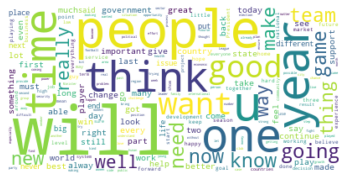

In [125]:
plot_wordcloud(country_quotes_2019_df)